In [74]:
#https://github.com/Kulbear/stock-prediction/blob/master/stock-prediction.ipynb
import time
import math
import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Concatenate
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt

In [273]:
def exp_loss(y_true, y_pred):
    return keras.backend.exp(keras.backend.abs(y_pred - y_true) / (y_true * y_true))

def build_model(size, window, num_neurons, out_dim, D = [0.1, 0.1, 0.1]):
    #Create RNN
    RNN = Sequential()
    #First LSTM Layer
    RNN.add(LSTM(num_neurons[0], input_shape=(window, size), return_sequences = False, dropout = D[0]))
    RNN.add(Activation('tanh'))
    
    #Second LSTM Layer
    #RNN.add(LSTM(num_neurons[1], return_sequences = False, dropout = D[1]))
    #RNN.add(Activation('tanh'))
    
    #Third LSTM Layer
    #RNN.add(LSTM(num_neurons[2], return_sequences = False, dropout = D[2]))
    #RNN.add(Activation('softmax'))

    #First Dense Layer
    #RNN.add(Dense(num_neurons[3]))
    #RNN.add(Activation('tanh'))
    
    #Second Dense Layer
    RNN.add(Dense(out_dim))
    RNN.add(Activation('tanh'))

    start = time.clock()
    #RNN.compile(loss='mean_squared_error', optimizer='adam')
    RNN.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    #RNN.compile(loss=exp_loss, optimizer='adam')
    print 'Compilation Time:', time.clock() - start
    return RNN

def normalize(data, alpha = 0.8, flip = True):
    #Normalize data to be between 0 and 1
    minimum = data.min()
    maximum = data.max()
    if flip:
        norm = alpha / (maximum - minimum) * (maximum - data)
    else:
        norm = alpha * (data - minimum) / (maximum - minimum)
    return norm, minimum, maximum

def unnormalize(data, minimum, maximum, alpha = 0.8):
    return maximum - data * (maximum - minimum) / alpha    

def preprocess_data(stock, sequence_length, forecast = 5, diff = 0, percent_train = 0.9):
    #Normalize data
    #stock, _, _ = normalize(stock)
    
    num_features = stock.shape[1]
    sequence_length += 1
    
    #Create array of windows
    result = np.zeros((len(stock) - sequence_length - forecast, sequence_length, num_features))
    for i in range(len(result)):
        result[i] = (stock[i:i + sequence_length])

    #Use certain percentage of the data for training
    cutoff = int(round(percent_train * len(result)))
    #cutoff = 810
       
    #y data is the last row of each window, X data is all other rows
    X_train = result[:cutoff-np.max([diff,0]),:-1,:]
    if diff > 0:
        X_test = result[cutoff-diff:-diff,:-1,:]
        y_train = result[diff:cutoff,-1,:]
    else:
        X_test = result[cutoff:,:-1,:]
        y_train = result[:cutoff,-1,:]
    y_test = result[cutoff:,-1,:]
    
    y_train = np.zeros((len(X_train),forecast))
    y_test = np.zeros((len(X_test),forecast))
    
    for i in range(len(y_train)):
        y_train[i] = stock[window+i:window+i+forecast,0]
    for i in range(len(y_test)):
        y_test[i] = stock[window+len(y_train)+i:window+len(y_train)+i+forecast,0]

    return [X_train, y_train, X_test, y_test]


#def forecast(X, model, time_steps = 10):
#    forecast = np.zeros((time_steps, X.shape[2]))    
#    for i in range(time_steps):
#        p = model.predict(X)
#        s = np.zeros(X.shape)
#        s[:,:-1] = X[:,1:]
#        s[:,-1] = p
#        X = np.copy(s)
#        forecast[i] = s[0,-1]
#        
#    return forecast

In [330]:
#data = np.loadtxt('DailyStocks.dat')
#data, d1, d2 = normalize(data)

data = np.loadtxt('DailyStocksBig.dat')
data, d1, d2 = normalize(data, flip = False)

google = np.loadtxt('Google.dat')[:,:4]
google, g1, g2 = normalize(google, flip = False)

apple = np.loadtxt('Apple.dat')[:,:4]
apple, a1, a2 = normalize(apple)

In [315]:
#model = load_model('RNN_Model_Best.h5')

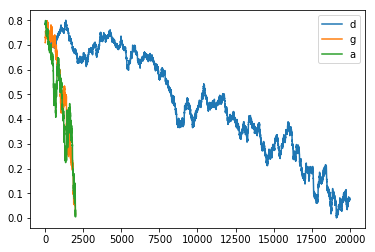

In [275]:
plt.plot(data[:,0], label='d')
plt.plot(google[:,0], label='g')
plt.plot(apple[:,0], label='a')
plt.legend()
plt.show()

In [332]:
window = 15
X_train, y_train, X_test, y_test = preprocess_data(data, window, percent_train = 1, forecast = 5)
google_train, ygoogletrain, _, _ = preprocess_data(google, window, percent_train = 1, forecast = 5)
apple_train, _, _, _ = preprocess_data(apple, window, percent_train = 1, forecast = 5)

print "X_train:", X_train.shape
print "y_train:", y_train.shape
print "X_test:", X_test.shape
print "y_test:", y_test.shape

X_train: (19979, 15, 4)
y_train: (19979, 5)
X_test: (0, 15, 4)
y_test: (0, 5)


In [265]:
#y_train = labels[window+1:window+1+len(X_train)]
#y_test = labels[window+1+len(X_train):window+1+len(X_train)+len(X_test)]

#print "X_train:", X_train.shape
#print "y_train:", y_train.shape
#print "X_test:", X_test.shape
#print "y_test:", y_test.shape

In [287]:
r = 64
num_neurons = [r, 2*r, 2*r, r]
num_inputs = X_train.shape[-1]
num_outputs = y_train.shape[-1]
model = build_model(num_inputs, window, num_neurons, num_outputs)

Compilation Time: 0.0368990000006


In [288]:
start = time.clock()
hist = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    verbose=0)
print time.clock() - start

model.save('RNN_Model.h5')

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.6f MSE (%.6f RMSE)' % (trainScore, math.sqrt(trainScore)))

#testScore = model.evaluate(X_test, y_test, verbose=0)
#print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

#testScore = model.evaluate(google_train, google_test, verbose=0)
#print('Google Score: %.6f MSE (%.6f RMSE)' % (testScore, math.sqrt(testScore)))

879.765449
Train Score: 10.449149 MSE (3.232514 RMSE)


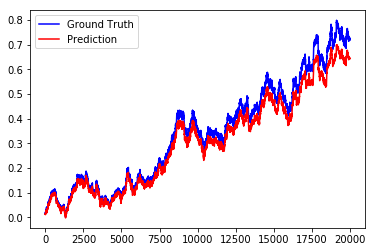

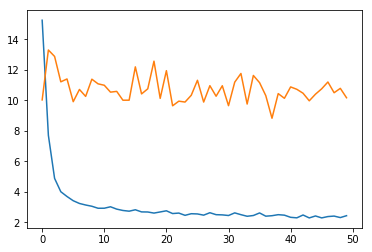

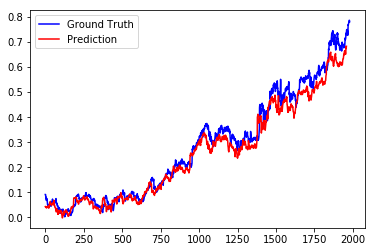

In [295]:
alpha = model.predict(X_train)[:,0]
plt.plot(y_train[:,0], 'b', label='Ground Truth')
plt.plot(alpha, 'r', label='Prediction')
#plt.plot(alpha[:,-1], 'g', label='Forecast')
#plt.plot(alpha - y_test[:,0,np.newaxis], label='Difference')
plt.legend(loc='best')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

alpha = model.predict(google_train)[:,-1]
plt.plot(google[:,0], 'b', label='Ground Truth')
plt.plot(alpha, 'r', label='Prediction')
plt.legend(loc='best')
plt.show()

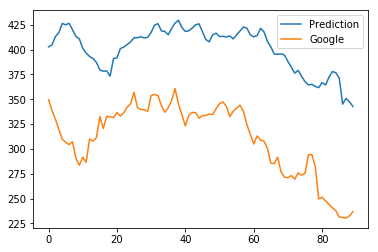

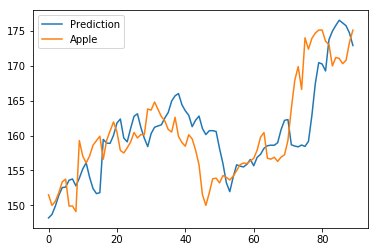

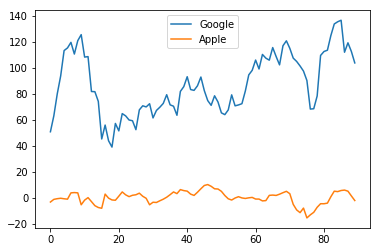

In [296]:
plt.plot(unnormalize(model.predict(google_train)[-90:,0],g1,g2), label = 'Prediction')
plt.plot(unnormalize(google,g1,g2)[-90:,0], label = 'Google')
plt.legend()
plt.show()

plt.plot(unnormalize(model.predict(apple_train)[-90:,0],a1,a2), label = 'Prediction')
plt.plot(unnormalize(apple,a1,a2)[-90:,0], label = 'Apple')
plt.legend()
plt.show()

plt.plot(unnormalize(model.predict(google_train)[-90:,-1],g1,g2) 
         - unnormalize(google,g1,g2)[-90:,0], label = 'Google')
plt.plot(unnormalize(model.predict(apple_train)[-90:,-1],a1,a2) 
         - unnormalize(apple,a1,a2)[-90:,0], label = 'Apple')
plt.legend()
plt.show()

In [282]:
np.savetxt('Predictions.dat', np.vstack((
    np.array(range(90)) - 90,
    unnormalize(google,g1,g2)[-90:,0],
    unnormalize(model.predict(google_train)[-90:,0],g1,g2),
    unnormalize(apple,a1,a2)[-90:,0],
    unnormalize(model.predict(apple_train)[-90:,0],a1,a2)
)).T)

In [346]:
google, mu, sig = normalize(googdata)

t = unnormalize(google, mu, sig)

In [18]:
google_train, google_test, _, _ = preprocess_data(googdata, window, percent_train = 1)

In [363]:
beta = model.predict(google_train)

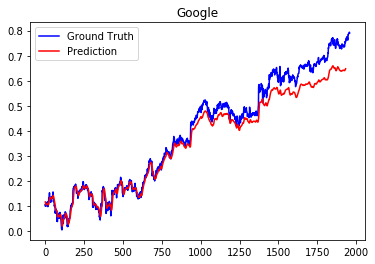

In [391]:
plt.plot(google[window:,0], 'b', label = 'Ground Truth')
plt.plot(beta[:-window,0], 'r', label = 'Prediction')
#plt.plot(beta[:,0] / google[:-26,0] - 1)
#plt.ylim(-0.5,0.5)
plt.title('Google')
plt.legend()
plt.show()

In [259]:
r = model.predict(google_train)

In [411]:
testScore = model.evaluate(google_train, google_test, verbose=0)
print('Test Score: %.6f MSE (%.6f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Test Score: 14.837807 MSE (3.851987 RMSE)


In [11]:
g = googdata[-250:]

In [14]:
gnorm, zeta, eta = normalize(g)
google_train, google_test, _, _ = preprocess_data(gnorm, window, percent_train = 1, forecast = 1)

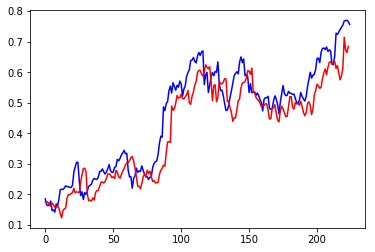

In [46]:
plt.plot(gnorm[window+5:,0], 'b')
plt.plot(model.predict(google_train)[:,0], 'r')
plt.show()

In [47]:
print len(gnorm[26:]), len(google_train)

224 224


In [48]:
print model.evaluate(google_train, google_test, verbose=0)

[9.7172826358250202, 0.10267857142857142]


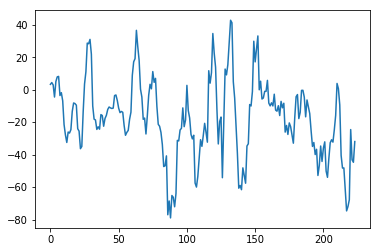

In [68]:
t = model.predict(google_train)
t = unnormalize(t, zeta, eta)
plt.plot(t[:,0] - googdata[-250+window+6:,0])
plt.show()

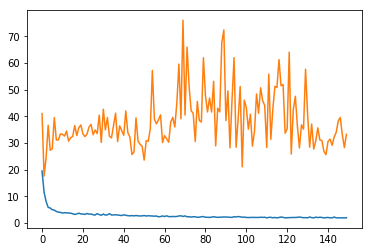

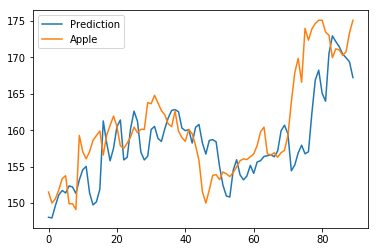

In [109]:
plt.plot(unnormalize(model.predict(apple_train)[-90:,0],a1,a2), label = 'Prediction')
plt.plot(unnormalize(apple,a1,a2)[-90:,0], label = 'Apple')
plt.legend()
plt.show()

In [327]:
ygood = y_train
alphagood = model.predict(X_train)[:,0]

In [318]:
#alphagood = model.predict(X_train)[:,0]
#y_train[:,0]

array([ 0.01509851,  0.01623793,  0.0156376 , ...,  0.72850711,
        0.72592115,  0.7253495 ])

In [328]:
print y_train[:,0].shape
print ygood.shape
print alphagood.shape
print alpha.shape


(19979,)
(19979, 5)
(19979,)
(19979,)


In [333]:
np.savetxt('BadNormal.dat', np.vstack((alpha, y_train[:,0], alphagood, ygood[:,0])).T)

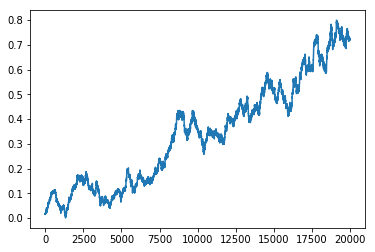

In [322]:
plt.plot(ygood)
plt.show()